<a href="https://colab.research.google.com/github/praveen1608/Praveen-Reddy_INFO5731_Spring2024/blob/main/Kadasani_PraveenReddy_Exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
# Write your code here
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')


def read_data(file_path):
    text_data, sentiments = [], []
    file_data = open(file_path).read()
    for i, j in enumerate(file_data.split("\n")):
        after_split = j.split(' ')
        text_data.append(" ".join(after_split[1:]))
        sentiments.append(after_split[0])
    return text_data, sentiments


def preprocess_data(data_frame):
    # Convert sentiment classes to integers
    data_frame['Sentimental Value'] = pd.to_numeric(data_frame['Sentimental Value'], errors='coerce')

    # Drop rows with NaN values in the target variable
    data_frame = data_frame.dropna(subset=['Sentimental Value'])

    # Pre-processing
    # removal of special characters
    data_frame['After noise removal'] = data_frame['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

    # removal of Punctuation
    data_frame['Punctuation removal'] = data_frame['After noise removal'].str.replace('[^\w\s]', '')

    # Stopwords removal
    stop_word = stopwords.words('english')
    data_frame['Stopwords removal'] = data_frame['Punctuation removal'].apply(
        lambda x: " ".join(word for word in x.split() if word not in stop_word))

    # Lower Casing
    data_frame['Lower casing'] = data_frame['Stopwords removal'].apply(lambda x: " ".join(word.lower() for word in x.split()))

    return data_frame


def vectorize_data(train_df, test_df):
    # TF-IDF Vectorization
    tfidf_vector = TfidfVectorizer(analyzer='word')
    tfidf_vector.fit(train_df['Lower casing'])
    x_train = tfidf_vector.transform(train_df['Lower casing'])
    tfidf_vector_test = TfidfVectorizer(analyzer='word', vocabulary=tfidf_vector.vocabulary_)
    tfidf_vector_test.fit(test_df['Lower casing'])
    x_test = tfidf_vector_test.transform(test_df['Lower casing'])

    return x_train, x_test


def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    accuracy = accuracy_score(predicted, y_test)
    print(f"Accuracy of Training data ({classifier.__class__.__name__}): {accuracy}")

    predicted_testing = classifier.predict(x_test)
    accuracy_testing = accuracy_score(predicted_testing, y_test)
    print(f"Accuracy of Testing data ({classifier.__class__.__name__}): {accuracy_testing}")

    if 'XGB' not in str(classifier):
        scoring = 'accuracy'
        kfold = KFold(10, random_state=7, shuffle=True)
        cross_val = cross_val_score(classifier, x_test, y_test, cv=kfold, scoring=scoring).mean()
        print(f"Cross-validation score ({classifier.__class__.__name__}): {cross_val}")

    print(f"\nClassification Report ({classifier.__class__.__name__}):\n")
    print(classification_report(y_test, predicted))


# Read data
training_text_data, training_sentiments = read_data('stsa-train.txt')
testing_text_data, testing_sentiments = read_data('stsa-test.txt')

# Create data frames
training_df = pd.DataFrame(list(zip(training_sentiments, training_text_data)), columns=['Sentimental Value', 'Raw Data'])
testing_df = pd.DataFrame(list(zip(testing_sentiments, testing_text_data)), columns=['Sentimental Value', 'Raw Data'])

# Pre-process data
training_df = preprocess_data(training_df)
testing_df = preprocess_data(testing_df)

# Vectorize data
x_train, x_test = vectorize_data(training_df, testing_df)

# Split data for training and testing
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, training_df['Sentimental Value'],
                                                                      test_size=0.2, random_state=42)

# Ensure target variables are integers
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

# List of classifiers
classifiers = [
    naive_bayes.MultinomialNB(),
    svm.SVC(),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Evaluate each classifier
for classifier in classifiers:
    print(f"Evaluating {classifier.__class__.__name__}:")
    evaluate_classifier(classifier, x_train, y_train, x_valid, y_valid)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Evaluating MultinomialNB:
Accuracy of Training data (MultinomialNB): 0.7911849710982659
Accuracy of Testing data (MultinomialNB): 0.7911849710982659
Cross-validation score (MultinomialNB): 0.7015848191012408

Classification Report (MultinomialNB):

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       671
           1       0.75      0.89      0.81       713

    accuracy                           0.79      1384
   macro avg       0.80      0.79      0.79      1384
weighted avg       0.80      0.79      0.79      1384

Evaluating SVC:
Accuracy of Training data (SVC): 0.796242774566474
Accuracy of Testing data (SVC): 0.796242774566474
Cross-validation score (SVC): 0.7008758210822645

Classification Report (SVC):

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       671
           1       0.77      0.86      0.81       713

    accuracy                           0.80      1384
   macro 

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [2]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
nltk.download('wordnet')

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')

print(df.head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0  


In [3]:
cluster_df = df.head(1000)
cluster_df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
995,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,It's a decent for the price.. I've had this on...,0.0
996,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,Is good cell phone,0.0
997,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,"Amazing phone. Cables and case included, also ...",0.0
998,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,Excelent,0.0


In [4]:
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

# Removal of special characters
cluster_df['Clean Text'] = cluster_df['Reviews'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

# Removal of punctuations
cluster_df['Clean Text'] = cluster_df['Clean Text'].str.replace('[^\w\s]', '')

# Removing numbers
cluster_df['Clean Text'] = cluster_df['Clean Text'].str.replace('\d+', '')

# Removal of stopwords
stop_words = set(stopwords.words('english'))
cluster_df['Clean Text'] = cluster_df['Clean Text'].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in stop_words))

# Lowercasing
cluster_df['Clean Text'] = cluster_df['Clean Text'].apply(lambda x: x.lower())

# Tokenization
cluster_df['Tokenization'] = cluster_df['Clean Text'].apply(lambda x: TextBlob(x).words)

# Stemming
porter_stemmer = PorterStemmer()
cluster_df['Stemming'] = cluster_df['Tokenization'].apply(lambda x: " ".join([porter_stemmer.stem(word) for word in x]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
cluster_df['Lemmatization'] = cluster_df['Stemming'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

# Display the processed data
cluster_df

<ipython-input-4-b8fe48cb6bb9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['Clean Text'] = cluster_df['Reviews'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))
<ipython-input-4-b8fe48cb6bb9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['Clean Text'] = cluster_df['Clean Text'].str.replace('[^\w\s]', '')
<ipython-input-4-b8fe48cb6bb9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Clean Text,Tokenization,Stemming,Lemmatization
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,pleased,[pleased],pleas,plea
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,works good goes slow sometimes good phone love,"[works, good, goes, slow, sometimes, good, pho...",work good goe slow sometim good phone love,work good goe slow sometim good phone love
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,great phone replace lost phone thing volume bu...,"[great, phone, replace, lost, phone, thing, vo...",great phone replac lost phone thing volum butt...,great phone replac lost phone thing volum butt...
...,...,...,...,...,...,...,...,...,...,...
995,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,It's a decent for the price.. I've had this on...,0.0,decent price one 6 months cons 1 pretty freque...,"[decent, price, one, 6, months, cons, 1, prett...",decent price one 6 month con 1 pretti frequent...,decent price one 6 month con 1 pretti frequent...
996,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,Is good cell phone,0.0,good cell phone,"[good, cell, phone]",good cell phone,good cell phone
997,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,"Amazing phone. Cables and case included, also ...",0.0,amazing phone cables case included also screen...,"[amazing, phone, cables, case, included, also,...",amaz phone cabl case includ also screen pritec...,amaz phone cabl case includ also screen pritec...
998,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,Excelent,0.0,excelent,[excelent],excel,excel


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

# Initialize TF-IDF vectorizer
tfidf_vect = TfidfVectorizer()

# Fit and transform the TF-IDF vectorizer on the lemmatized text data
tfidf_matrix = tfidf_vect.fit_transform(cluster_df['Lemmatization'].values)

# Get the shape of the TF-IDF matrix
tfidf_shape = tfidf_matrix.shape

# Initialize KMeans model with 10 clusters
model_tf = KMeans(n_clusters=10, random_state=99)

# Fit KMeans model to the TF-IDF matrix
model_tf.fit(tfidf_matrix)

# Get cluster labels
cluster_labels = model_tf.labels_

# Get cluster centers
cluster_centers = model_tf.cluster_centers_

# Get feature names from TF-IDF vectorizer
feature_names = tfidf_vect.get_feature_names_out()

# Calculate silhouette score
silhouette_score_tf = metrics.silhouette_score(tfidf_matrix, cluster_labels, metric='euclidean')

# Assign cluster labels to the dataframe
cluster_df['TF-IDF Cluster Label'] = model_tf.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-5-d8258aedb90b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['TF-IDF Cluster Label'] = model_tf.labels_


In [6]:
cluster_df.groupby(['TF-IDF Cluster Label'])['Reviews'].count()


TF-IDF Cluster Label
0     29
1     52
2     43
3     50
4    126
5    538
6     51
7     55
8     35
9     21
Name: Reviews, dtype: int64

In [7]:
print("Top terms per cluster:")
cluster_centers_sorted = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print("Cluster %d:" % i, end='')
    for index in cluster_centers_sorted[i, :10]:
        print(' %s' % feature_names[index], end='')
    print()

Top terms per cluster:
Cluster 0: great phone work expect luv product price easi fast buy
Cluster 1: excel product recommend seller thank 100 phone fash function five
Cluster 2: fine like work instruct far cover phone would seem sim
Cluster 3: good phone product price thank cell mobil work go buy
Cluster 4: phone use sim card like work call screen review would
Cluster 5: phone good use charg work one screen buy bad batteri
Cluster 6: love phone use buy great like mom best smartphon easi
Cluster 7: work phone item lousi die arriv speaker return avert well
Cluster 8: excelent telefono muy bueno producto zip fanci fashion fash farsight
Cluster 9: ok far wcdma quit peopl someon buy slow oftenneg enter


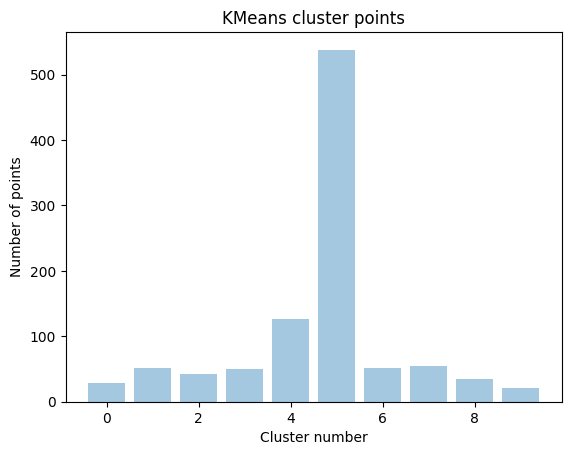

In [8]:
import matplotlib.pyplot as plt
plt.bar([x for x in range(10)], cluster_df.groupby(['TF-IDF Cluster Label'])['Reviews'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()


In [9]:
for i in range(10):
    print("Four review of assigned to the cluster: ", i)
    print("-" * 70)
    print(cluster_df.iloc[cluster_df.groupby(['TF-IDF Cluster Label']).groups[i][0]]['Reviews'])
    print('\n')
    print(cluster_df.iloc[cluster_df.groupby(['TF-IDF Cluster Label']).groups[i][5]]['Reviews'])
    print('\n')
    print(cluster_df.iloc[cluster_df.groupby(['TF-IDF Cluster Label']).groups[i][10]]['Reviews'])
    print('\n')
    print("_" * 70)

Four review of assigned to the cluster:  0
----------------------------------------------------------------------
Phone good just a little slow phone old but it's a great phone temporary right now. thank you for the great deal


Met all of my expectations. I can't complain at all. Great price!


Works great.


______________________________________________________________________
Four review of assigned to the cluster:  1
----------------------------------------------------------------------
excellent product in perfect condition


Excellent phone has all the special functions to be communicated with all social networks, excellent operational...I recommend it 100% excellent product


Excelent


______________________________________________________________________
Four review of assigned to the cluster:  2
----------------------------------------------------------------------
Had this phone before and loved it but was not working so I got this phone. One thing is the SD card slot does 

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

# Initialize CountVectorizer
count_vect = CountVectorizer()

# Fit and transform CountVectorizer on the 'Reviews' column
bow_matrix = count_vect.fit_transform(cluster_df['Reviews'].values)

# Get the shape of the bag-of-words matrix
bow_shape = bow_matrix.shape

# Initialize KMeans model with 10 clusters
model = KMeans(n_clusters=10, init='k-means++', random_state=99)

# Fit KMeans model to the bag-of-words matrix
model.fit(bow_matrix)

# Get cluster labels
labels = model.labels_

# Get cluster centers
cluster_centers = model.cluster_centers_

# Calculate silhouette score
silhouette_score_bow = metrics.silhouette_score(bow_matrix, labels, metric='euclidean')

# Assign cluster labels to the dataframe
cluster_df['BoW Cluster Label'] = model.labels_
cluster_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-5007f5111e5f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['BoW Cluster Label'] = model.labels_


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Clean Text,Tokenization,Stemming,Lemmatization,TF-IDF Cluster Label,BoW Cluster Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...,4,9
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...,5,0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,pleased,[pleased],pleas,plea,5,0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,works good goes slow sometimes good phone love,"[works, good, goes, slow, sometimes, good, pho...",work good goe slow sometim good phone love,work good goe slow sometim good phone love,3,0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,great phone replace lost phone thing volume bu...,"[great, phone, replace, lost, phone, thing, vo...",great phone replac lost phone thing volum butt...,great phone replac lost phone thing volum butt...,5,9


In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

In [12]:
# Setting the minimum number of points for density-based clustering
minPts = 2 * 100

# Lower bound function to find the element just greater than or equal to the target in a sorted array
def lower_bound(nums, target):
    l, r = 0, len(nums) - 1
    while l <= r:
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

# Computes the distance to the 200th nearest neighbor for a given data point x
def compute_200th_nearest_neighbour(x, data):
    dists = []
    for val in data:
        # Computing Euclidean distance between points
        dist = np.sum((x - val) ** 2)
        # Updating the list with the 200 smallest distances encountered so far
        if len(dists) == 200 and dists[199] > dist:
            # Finding the right position using the lower bound function
            l = int(lower_bound(dists, dist))
            # Ensuring the new distance is smaller than the current largest distance
            if 0 <= l < 200 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()

    # The 200th nearest neighbor distance is stored at index 199
    return dists[199]

In [13]:
list_of_sent_train = list()
for i in cluster_df["Clean Text"].values:
    list_of_sent_train.append(i.split())


In [14]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train, vector_size=100, workers=4)

In [15]:
import numpy as np

# Initialize an empty list to store the average Word2Vec representation for each sentence/review
sent_vectors = []

# Counter for tracking the number of processed sentences/reviews
count = 1

# Iterate through each sentence/review in the training dataset
for sent in list_of_sent_train:
    # Initialize a vector of zeros with a length of 100 (size of Word2Vec vectors)
    sent_vec = np.zeros(100)

    # Initialize a counter for the number of words with a valid vector in the sentence/review
    cnt_words = 1

    # Iterate through each word in the sentence/review
    for word in sent:
        try:
            # Attempt to retrieve the Word2Vec vector for the current word
            vec = w2v_model.wv[word]

            # Add the vector to the sentence vector
            sent_vec += vec

            # Increment the word count
            cnt_words += 1
        except:
            # If the word is not in the Word2Vec model's vocabulary, ignore the exception
            pass

    # Calculate the average vector for the sentence/review
    sent_vec /= cnt_words

    # Append the average vector to the list of sentence vectors
    sent_vectors.append(sent_vec)

# Convert the list of sentence vectors to a NumPy array
sent_vectors = np.array(sent_vectors)

# Replace any NaN values with zeros
sent_vectors = np.nan_to_num(sent_vectors)

In [16]:
twohundrethneigh = []
for val in sent_vectors[:300]:
    twohundrethneigh.append(compute_200th_nearest_neighbour(val, sent_vectors[:300]) )
twohundrethneigh.sort()

In [17]:
model = DBSCAN(eps = 5, min_samples = minPts, n_jobs=-1)
model.fit(sent_vectors)

DBSCAN(eps=5, min_samples=200, n_jobs=-1)

In [18]:
cluster_df['AVG-W2V Clus Label'] = model.labels_
cluster_df.head()

<ipython-input-18-de1216c26220>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AVG-W2V Clus Label'] = model.labels_


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Clean Text,Tokenization,Stemming,Lemmatization,TF-IDF Cluster Label,BoW Cluster Label,AVG-W2V Clus Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...,4,9,0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...,5,0,0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,pleased,[pleased],pleas,plea,5,0,0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,works good goes slow sometimes good phone love,"[works, good, goes, slow, sometimes, good, pho...",work good goe slow sometim good phone love,work good goe slow sometim good phone love,3,0,0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,great phone replace lost phone thing volume bu...,"[great, phone, replace, lost, phone, thing, vo...",great phone replac lost phone thing volum butt...,great phone replac lost phone thing volum butt...,5,9,0


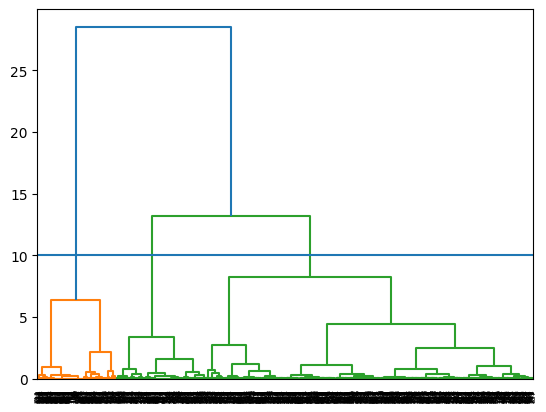

In [19]:
import scipy
from scipy.cluster import hierarchy
dendro = hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method = 'ward'))
plt.axhline(y = 10) # cut at 30 to get 5 clusters

In [20]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve
Agg=cluster.fit_predict(sent_vectors)

#Giving Labels/assigning a cluster to each point/text
aggdfa = cluster_df
aggdfa['AVG-W2V Clus Label'] = cluster.labels_
aggdfa.groupby(['AVG-W2V Clus Label'])['Reviews'].count()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
<ipython-input-20-4b3f08671a2d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggdfa['AVG-W2V Clus Label'] = cluster.labels_


AVG-W2V Clus Label
0    500
1    157
2    184
3     66
4     93
Name: Reviews, dtype: int64

In [21]:
for i in range(5):
    print("Two reviews of assigned to cluster ", i)
    print("-" * 70)
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['Reviews'])
    print('\n')
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['Reviews'])
    print('\n')
    print("_" * 70)

Two reviews of assigned to cluster  0
----------------------------------------------------------------------
I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!


nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung


______________________________________________________________________
Two reviews of assigned to cluster  1
----------------------------------------------------------------------
It works good but it goes slow sometimes but its a very good phone I love it


Great phone to replace my lost phone. 

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

With k-means, we split a large set into groups, then shape them differently. It works well with big sets, not so much with noisy data. DBscan tells apart dense clusters from sparse ones. It's good with noisy data, but not with big sets. Hierarchical clustering merges alike parts into groups. Sorting clusters is tough using Hierarchical Clustering.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [22]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Through this exercise I got hands on experience with Text classification and clustering. I would say working on this exercise is not easy when compared to previous ones.
I have faced few issues while working on BERT and word2Vec in question number 1. It took a while to run the code. The processes like stemming, lemmatization all have been
reviced once again. Time for doing the exercise is okay, but faced few issues with runtime.





'''

'\nThrough this exercise I got hands on experience with Text classification and clustering. I would say working on this exercise is not easy when compared to previous ones.\nI have faced few issues while working on BERT and word2Vec in question number 1. It took a while to run the code. The processes like stemming, lemmatization all have been\nreviced once again. Time for doing the exercise is okay, but faced few issues with runtime.\n\n\n\n\n\n'